In [57]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree



# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor


from tqdm import tqdm

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [58]:
from src import soporte_ajuste as sa

In [59]:
df = pd.read_csv("datos/datos_preprocesados.csv",index_col=0)

In [60]:
df.head()

,price,size,municipality,distance,hasVideo,status,hasPlan,has3DTour,floor,hasLift,...,rooms_3,rooms_4,bathrooms_1,bathrooms_2,bathrooms_3,showAddress_False,showAddress_True,has360_False,has360_True,has360_desconocido
0,750.0,0.12,0.445948,-0.252799,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
1,750.0,0.52,0.038221,0.182949,1.0,0.0,1.0,0.0,-0.756628,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,715.0,0.00,0.038221,-0.020333,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,590.0,0.52,-2.098184,2.118218,0.0,0.0,0.0,0.0,-1.114680,0.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,715.0,0.00,0.038221,-0.020333,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Separamos la variable respuesta del resto de variables
X = df.drop(columns="price")
y = df[["price"]]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)


In [63]:
np.set_printoptions(suppress= True)
# Establecemos un diccionario con los hiperparámetros
params_gb={    
    'n_estimators': [40, 50, 60, 70],    #número de árboles que queremos que haga
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'max_leaf_nodes': [3, 4, 5]
}

In [64]:
modelo_gb = GradientBoostingRegressor(random_state=42)
random_search_gb= GridSearchCV(modelo_gb,
                             params_gb,
                             cv=3,
                             scoring= "neg_mean_squared_error",
                             n_jobs=-1)

random_search_gb.fit(X_train,y_train["price"].values)   
modelo_final_gb= random_search_gb.best_estimator_
modelo_final_gb

GradientBoostingRegressor(max_leaf_nodes=4, min_samples_leaf=3, n_estimators=50,
                          random_state=42)

In [65]:
y_pred_test = modelo_final_gb.predict(X_test)
y_pred_train = modelo_final_gb.predict(X_train)

In [66]:
df_metricas_rf = sa.metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_rf

,r2_score,MAE,MSE,RMSE
train,0.619681,24.158660,1086.195284,32.957477
test,0.548003,30.315264,1451.347955,38.096561


El modelo no es bueno, y si bajamos el tamaño de train_test obtenemos metricas peores, y más overfitting del que ya hay. Las metricas en test son muy similares a las del RandomForest.

Comparamos los precios predichos con los precios de los datos originales.

In [67]:
y_train.reset_index(inplace= True)
df_predicted = pd.DataFrame(y_pred_train)
df_predicted.rename(columns = {0:"predicted"}, inplace=True)
df_precios = pd.concat([df_predicted, y_train], axis=1)
df_precios.drop(columns = "index", inplace= True)
df_precios.head(5)

,predicted,price
0,712.990629,750.0
1,708.311452,600.0
2,714.474794,700.0
3,722.727985,720.0
4,716.331939,715.0


Vamos a ver la importancia de cada variable y tal vez saquemos alguna conclusión para futuras mejoras del modelo

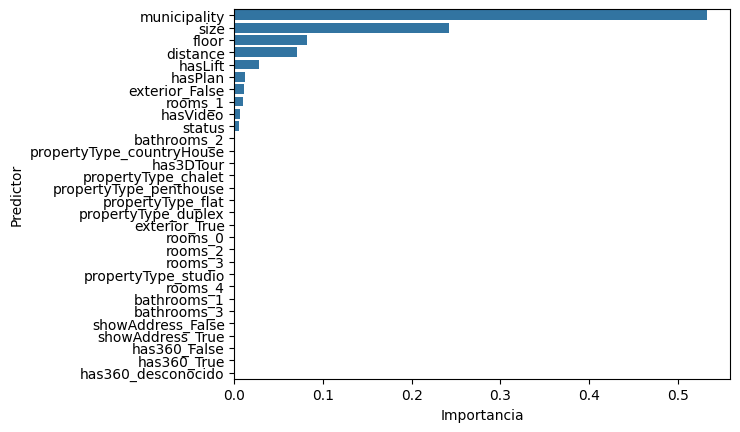

In [68]:
importancias = modelo_final_gb.feature_importances_
importancia_rf = pd.DataFrame({"Predictor": X_train.columns, "Importancia": importancias})
importancia_rf = importancia_rf.sort_values(by="Importancia", ascending=False)
sns.barplot(y = "Predictor", x = "Importancia", data = importancia_rf);

Tenemos muchas variables con importancia nula que eliminaremos en proximos modelos.